# Image Production

This notebook walks through the production of images used in the presentation and in other files within this repo.  The initial import cells below must be ran, following this all cells can be ran independently.  The document is organized as follows:


## Table of contents
### 0) Initial Imports
### 1) Overlap Plots
### 2) LIME images
### 3) Sorting Video
### 4) Bar Chart 
### 5) Confusion Matrix

In [2]:
import viz_package

We first import our primary model, as it will be used for many of the visualizations. 

In [25]:
from tensorflow import keras
model=keras.models.load_model('bobby_best/cnn')

We then bring in our main working data, using the "process_and_split_data" method in the viz_package package, with default arguments.  This method takes in our data in its provided form, three folders named "train, test, and val" (a pre-existing division we'll dispense with) and outputs the images, labels, and then those two again but divided into train, test, and validation portions.  

In [26]:
images,labels,X_train,y_train,X_test,y_test,X_val,y_val=viz_package.process_and_split_data()

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


It will be useful to see the categorical predicted labels for the test set, which we do below:

In [35]:
test_pred_cat=model.predict_classes(X_test).flatten()

In [36]:
test_pred_cat.sum()

69

In [37]:
display(test_pred_cat)

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1])

## Making the two overlap plots

Here, we create overlap plots to get a feel for how consistent the images are and to try to identify any natural patterns that could exist between the two cases.  The overlap_images method is used here, which takes in an array of equally sized images and does creates 3 plots:

1. The main plot, which is created by averaging all pixels of the same (x,y) coordinate across the array of images, in essence "stacking" all the x-rays.  
2. The plot at the top of the top of the graph, which then finds the average value of each pixel in the column of pixels directly below, in effect then "flattening vertically".  
3. The plot on the right, which does the same as the previous plot but horizontally. 

Notice that the brightness plots have curve-axis filling only for the sake of readability.  Similarly, as these are used for qualitative grasping no scale is provided for the brightness; relative brightness within and between graphs is what is useful to see here.  

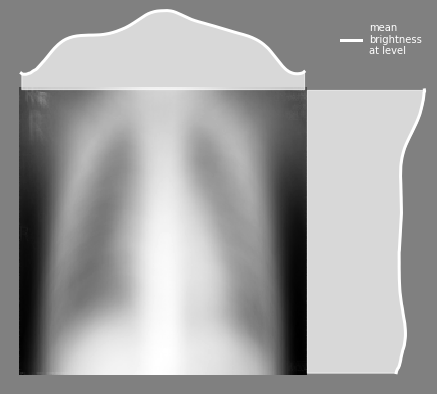

In [21]:
pneu=images[labels==1][:,:,:,0]
#Define the pneumonia x-rays by selecting those images with a corresponding label of 1
r=viz_package.overlap_images(pneu)
r.savefig('pneu_overlap.png',bbox_inches='tight',transparent=True)
#Pass bbox_inches=tight to ensure the entire figure is captured, as the function being used creates new axes after initial figure creation.
r
#The result is called here just so it can be seen in the jupyter notebook

## Lime code: just given directly

We import lime and instantiate an explainer instance.  No best practices yet exist for deciding on a kernel width here, "playing around" is explicitly recommended in lime documentations.  One runs the risk of massaging data to look like what is desired in cases like this, so only a few were tried and .5 seemed to give reasonable, not overly-flattering results. 

In [144]:
import lime
from lime import lime_image
from skimage.color import label2rgb
from skimage.color import rgb2gray
from skimage.color import gray2rgb
explainer=lime_image.LimeImageExplainer(random_state=98,kernel_width=.5)
#instantiate the explainer

LIME expects rgb images wil be passed to it, along with a prediction function for rgb images.
As such we define a function that takes an rgb image, maps it to gray, and passes that through our model's .predict method.

We also define a list of images to investigate, sending each through skimage's gray2rgb method.

In [570]:
def rgb_pred(x):
    '''
    Take in an array of RGB images, map them to grayscale, send to model.predict
    '''
    x=rgb2gray(x).reshape(*rgb2gray(x).shape,1)   
    return model.predict(x)

rng=np.random.default_rng(seed=98)
access=rng.integers(0,labels.shape[0],16)
#Instantiate an RNG, us it to select 16 indices from our list of images
X_lime=images[access]
#Pick those 16 random images
X_lime=np.apply_along_axis(gray2rgb,-2,X_lime)[:,:,:,:,0]
#Send those images through gray2rgb, so they can be used with LIME
y_lime=labels[access]
#We also get the corresponding labels (this is the reason for the awkard rng method), which we'll use for annotating the plots.

A single image can then be examined by passing the image into LIME's explain_instnance and sending that through label2rgb and imshow:

(-0.5, 223.5, 223.5, -0.5)

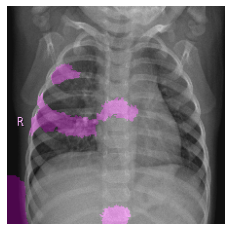

In [159]:
import matplotlib.pyplot as plt
entry=explainer.explain_instance(X_lime[0],rgb_pred,num_samples=1000,random_seed=98)
#Sample size should be increased to 1000 to see results used in notebook or presentation
#With only ten samples there is a tremendous amount of variation between runs, the image only serves to show LIME working.
temp,mask=entry.get_image_and_mask(0)
#this is a binary classification problem, the label must be 0
plt.imshow(label2rgb(mask,temp,colors=[(.2,.2,.2),(1,.1,1)]))
#We set the default color to grey, the color of interest to violet. 
plt.axis('off')
plt.title(y_lime[0])

For the actual evaluation of model performance, we instead look at an array of those 16 randomly chosen images.  This is done using the same method as above, but each image is instead stored in a list which is then used for the plotting.  Unfortunately there is no good way known to the authors to stop the repeated tqdm output. 

After computing each element of limelist, we also save the result so that it can be quickly restored.  The actual generation is blocked out here, and instead we create the result by loading those stored values. 

In [571]:
# lime_list=[]
# # # Creating the values: 
# for n in range(y_lime.shape[0]):
#     entry=explainer.explain_instance(X_lime[n],rgb_pred,num_samples=1000)
#     temp,mask=entry.get_image_and_mask(0)
#     lime_list.append([mask,temp])   

#Storing the values:
# for count,pair in enumerate(lime_list):
#     print(pair[0].mean())
#     print(pair[1].mean())
#     print(type(pair))
#     np.save(fr'lime_folder\mask_{count}',pair[0])
#     np.save(fr'lime_folder\temp_{count}',pair[1])

#loading the values:
lime_list_safe=[]
for n in range(y_lime.shape[0]):
    temp,mask=np.load(fr'lime_folder\temp_{n}.npy'),np.load(fr'lime_folder\mask_{n}.npy')
    lime_list_safe.append([mask,temp])     

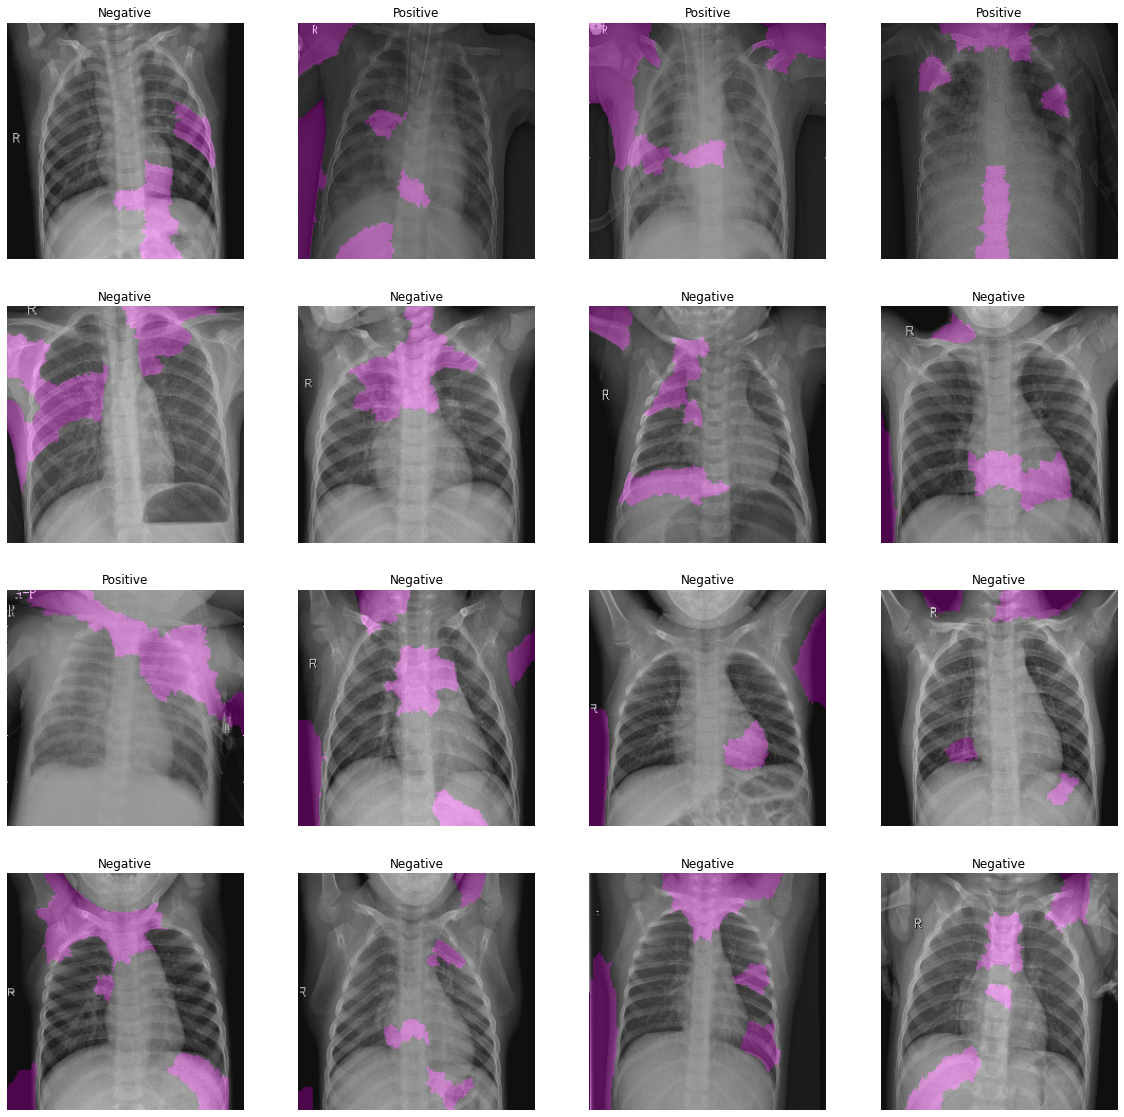

In [279]:
fig,axs=plt.subplots(4,4,figsize=(20,20))
#Set up subplots
for k,p in enumerate(lime_list_safe):
    #run through picture, using the counter in enumerate to move through the list of axes produced by subplots.  
    #print(k//4, k%4) can be used to check how this proceeds.  
    axs[k//4,k%4].imshow(label2rgb(*p,colors=[(.2,.2,.2),(1,.1,1)]))
    axs[k//4,k%4].set_axis_off()
    axs[k//4,k%4].set_title("Positive" if y_lime[k] else "Negative")

## Sorting graphic

In [202]:
u=viz_package.binary_sorting_viz(y_test,test_pred_cat,steps=500,pause=100,cols=['m','g'],target_phenomenon='Pneumonia')
u.save('sorting_performance_vid.mp4',fps=600/10)
#the total number of frames is steps+pause, so 600 here.  So if we want a 10 second film, we want an fps of 600/10. 
#Just to see that it works correctly
from IPython.display import HTML
HTML(u.to_html5_video())

# Bar Chart: Test Data

Here, we first bring in data that's sorted into bins of either "normal","pneumonia", or "not useable".  Not useable data is considered to be data falling below a predicted probability of 0.95 and above 0.05 for our model.  This choice is somewhat arbitrary but a fairly common ratio for similar-in-spirit cutoffs throughout the applied fields.  Actual optimization of such a value is beyond the scope of this work.   

The package below takes in the model and the data the division is sought for and outputs the data that "passes" (in the form of the predicted categorical labels on that data), the data that "fails" (in the same form) and the index that was discovered, which can then be used in further applications. 

Finding the heights of the bars for the useable data is easy, as we can just sum the values of the "good" set for the number of class 1 values, then sum the values of 1 minus the good set (broadcasting) for the number of class 0 values (1-1=0, 1-0=1).

In [325]:
good,nogo,indexer=viz_package.pred_sorter(model,X_test)
#Separate the test data into useable and non-useable portions. 

In [1]:
X_test.shape[0]

NameError: name 'X_test' is not defined

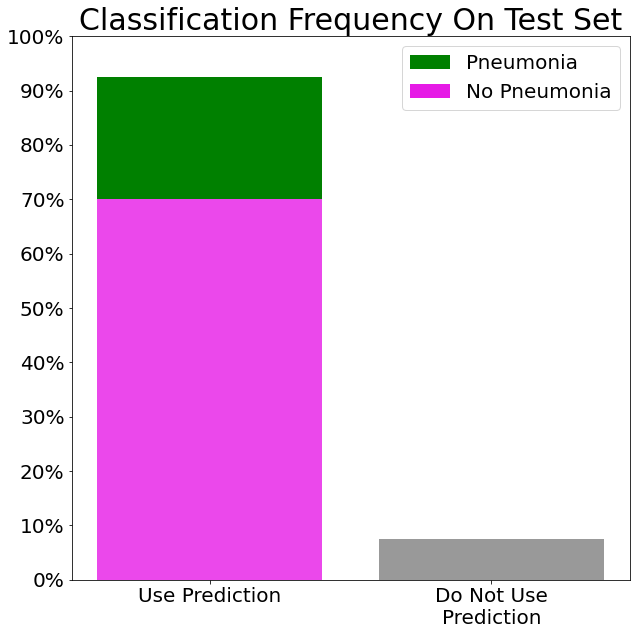

In [546]:
from matplotlib.ticker import StrMethodFormatter
from matplotlib.patches import Patch
u=plt.figure(figsize=(10,10))
plt.ylim(0,1)
plt.bar([0,1],[((1-good).sum())/(X_test.shape[0]),(nogo.shape[0])/X_test.shape[0]],color=[np.array([.9,.1,.9]),'gray'],alpha=.8);
#Create the bars for "normal" and "unused"
#All values are divided by the total number of values to get a percentage
plt.bar([0],(good.sum())/(X_test.shape[0]),bottom=((1-good).sum())/(X_test.shape[0]),color='g')
#Put the "pneumonia" bar on top of the "normal" bar
plt.xticks([0,1],['Use Prediction','Do Not Use\nPrediction'],fontsize=20);
plt.yticks(np.arange(0,1.1,.1),size=20)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0%}'))
plt.title('Classification Frequency On Test Set',size=30)
plt.legend([Patch(facecolor='green'),Patch(facecolor=(.9,.1,.9))],['Pneumonia','No Pneumonia'], prop={'size': 20})

u.savefig('stackedbarplot.png',bbox_inches='tight')

## Confusion matrix

sens 0.9710144927536232
spec 0.9891304347826086


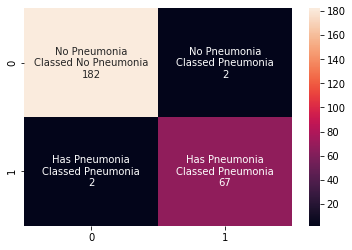

In [39]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cf=confusion_matrix(y_test,test_pred_cat)
tn,fp,fn,tp=cf.ravel()
print('sens',tp/(tp+fn))
print('spec',tn/(fp+tn))
sns.heatmap(cf,annot=[[f'No Pneumonia\nClassed No Pneumonia\n{tn}',f'No Pneumonia\nClassed Pneumonia\n{fp}'],
                      [f'Has Pneumonia\nClassed Pneumonia\n{fn}',f'Has Pneumonia\nClassed Pneumonia\n{tp}']],fmt="")
plt.show()